# Test different parameters systematically for sigma clipping, consecutive points in appaloosa

First, execute the following cell for different parameters, then store the results in folders accordingly, add the record to the spreadsheet. Before, execute cell below to load necessary modules.

In [2]:
for oid in oid_list:
    RunLC_test(oid)

/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

228682441	2018-03-02 13:48:26.213998	5	stars_shortlist/M67/hlsp_everest_k2_llc_228682441-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61103845



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211410963	2018-03-02 13:48:26.772000	15	stars_shortlist/M67/hlsp_everest_k2_llc_211410963-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61102064



/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: divide by zero encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in greater
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:96: RuntimeWarning: divide by zero encountered in true_divide
  _f

211411112	2018-03-02 13:48:27.455438	13	stars_shortlist/M67/hlsp_everest_k2_llc_211411112-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61102002



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211416648	2018-03-02 13:48:28.106468	15	stars_shortlist/M67/hlsp_everest_k2_llc_211416648-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61101947



/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and wi

211396422	2018-03-02 13:48:28.886387	5	stars_shortlist/M67/hlsp_everest_k2_llc_211396422-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.6110411



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211412571	2018-03-02 13:48:29.443055	22	stars_shortlist/M67/hlsp_everest_k2_llc_211412571-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61101854



/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: divide by zero encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in greater
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:96: RuntimeWarning: divide by zero encountered in true_divide
  _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: overflow encountered in exp
  lambda x: (_fd[0]*np

211418561	2018-03-02 13:48:30.030270	14	stars_shortlist/M67/hlsp_everest_k2_llc_211418561-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61101919



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211418176	2018-03-02 13:48:30.661371	7	stars_shortlist/M67/hlsp_everest_k2_llc_211418176-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.611019



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211403974	2018-03-02 13:48:31.243875	4	stars_shortlist/M67/hlsp_everest_k2_llc_211403974-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61102172



/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: divide by zero encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in greater
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:96: RuntimeWarning: divide by zero encountered in true_divide
  _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not 

211417817	2018-03-02 13:48:32.166104	9	stars_shortlist/M67/hlsp_everest_k2_llc_211417817-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61101863



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211413212	2018-03-02 13:48:32.717075	47	stars_shortlist/M67/hlsp_everest_k2_llc_211413212-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61101805



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211427268	2018-03-02 13:48:33.602413	12	stars_shortlist/M67/hlsp_everest_k2_llc_211427268-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61102921



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211395699	2018-03-02 13:48:34.178983	13	stars_shortlist/M67/hlsp_everest_k2_llc_211395699-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61104284



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211411894	2018-03-02 13:48:34.743376	6	stars_shortlist/M67/hlsp_everest_k2_llc_211411894-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61101788



/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:703: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  sig_i = np.nanmedian(rolling_std(flux, std_window, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: divide by zero encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in true_divide
  flare = np.piecewise(t, [(

211406540	2018-03-02 13:48:35.249307	3	stars_shortlist/M67/hlsp_everest_k2_llc_211406540-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.6110533



/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:703: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  sig_i = np.nanmedian(rolling_std(flux, std_window, center=True))
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


211407971	2018-03-02 13:48:35.744854	12	stars_shortlist/M67/hlsp_everest_k2_llc_211407971-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61101844



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211411722	2018-03-02 13:48:36.290655	7	stars_shortlist/M67/hlsp_everest_k2_llc_211411722-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61105339



/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:703: FutureWarning: pd.rolling_std is deprecated for 

211427574	2018-03-02 13:48:36.823975	6	stars_shortlist/M67/hlsp_everest_k2_llc_211427574-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61103736



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211409099	2018-03-02 13:48:37.397490	4	stars_shortlist/M67/hlsp_everest_k2_llc_211409099-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61105375



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211405388	2018-03-02 13:48:37.994285	8	stars_shortlist/M67/hlsp_everest_k2_llc_211405388-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61105354



/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: divide by zero encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in greater
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:96: RuntimeWarning: divide by zero encountered in true_divide
  _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not 

211411477	2018-03-02 13:48:39.314904	10	stars_shortlist/M67/hlsp_everest_k2_llc_211411477-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61105357



## Load all necessary modules and the list of EPIC IDs for the test sample

In [27]:
import pandas as pd
import numpy as np
import os
from appaloosa import RunLC
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
#rcParams['font.sans-serif'] = ['Tahoma']
os.chdir('/home/ekaterina/Documents/appaloosa/appaloosa')
def RunLC_test(oid):
    loc = 'stars_shortlist/M67'
    tpf_loc = 'stars_shortlist/M67/ktwo{}-c05_lpd-targ.fits.gz'.format(oid)
    lc_loc = 'stars_shortlist/M67/hlsp_everest_k2_llc_{}-c05_kepler_v2.0_lc.fits'.format(oid)
    os.chdir('/home/ekaterina/Documents/appaloosa')
    RunLC(lc_loc, dbmode='everest', display=False, debug=False, dofake=False, writeout=True)
    return

os.chdir('/home/ekaterina/Documents/appaloosa')
oid_list = pd.read_csv('stars_shortlist/M67/M67_short.txt',names=['EPIC'])
oid_list = oid_list.EPIC.tolist()

## Now move to the stored tests and define the folder suffixes from where to use the results

In [28]:
loc = '/home/ekaterina/Documents/appaloosa/stars_shortlist/M67/results'

test_collection = pd.DataFrame({'title':['Number of consecutive points threshold test: (N1 = 3 sigma, N2 = 2 sigma)',
                           'Sigma clipping threshold test: (N3(consecutive points) = 3, N2 = 2 sigma)',
                           'Sigma clipping threshold test: (N3(consecutive points) = 3, N1 = 4 sigma)',
                           'Sigma clipping threshold test: (N3(consecutive points) = 3, N1 = 3 sigma)',
                           'Using corrected EVEREST LCs\nNumber of consecutive points threshold test: (N1 = 3 sigma, N2 = 2 sigma)',
                           'Corrected vs. uncorrected EVEREST LCs\n (N1 = 3 sigma, N2 = 2 sigma, N3 = 3 consecutive points)',
                           ],
                  'tests': [[('_01','3 points'),('_02','4 points'),('_03','5 points')],
                           [('_06','2 sigma'),('_01','3 sigma'),('_04','4 sigma')],
                           [('_04','2 sigma'),('_07','1 sigma'),('_08','0 sigma')],
                           [('_01','2 sigma'),('_09','1 sigma'),('_10','0 sigma')],
                           [('_11','3 points'),('_12','4 points'),('_13','5 points')],
                           [('_01','uncorrected'),('_11','corrected')]
                           ],
                  'name':['N3','N1','N2','N2','N3','EVEREST']})

pd.set_option('max_colwidth',400)
print(test_collection)

  name     tests                                                 \
0       N3  [(_01, 3 points), (_02, 4 points), (_03, 5 points)]   
1       N1     [(_06, 2 sigma), (_01, 3 sigma), (_04, 4 sigma)]   
2       N2     [(_04, 2 sigma), (_07, 1 sigma), (_08, 0 sigma)]   
3       N2     [(_01, 2 sigma), (_09, 1 sigma), (_10, 0 sigma)]   
4       N3  [(_11, 3 points), (_12, 4 points), (_13, 5 points)]   
5  EVEREST               [(_01, uncorrected), (_11, corrected)]   

  title                                                                                                    
0                               Number of consecutive points threshold test: (N1 = 3 sigma, N2 = 2 sigma)  
1                               Sigma clipping threshold test: (N3(consecutive points) = 3, N2 = 2 sigma)  
2                               Sigma clipping threshold test: (N3(consecutive points) = 3, N1 = 4 sigma)  
3                               Sigma clipping threshold test: (N3(consecutive points) = 3, N1 = 3

In [29]:
title, tests, name = test_collection.iloc[0][['title','tests','name']]
tests

[('_01', '3 points'), ('_02', '4 points'), ('_03', '5 points')]

## Before doing the big analysis, explore the differences between the results for a single light curve

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


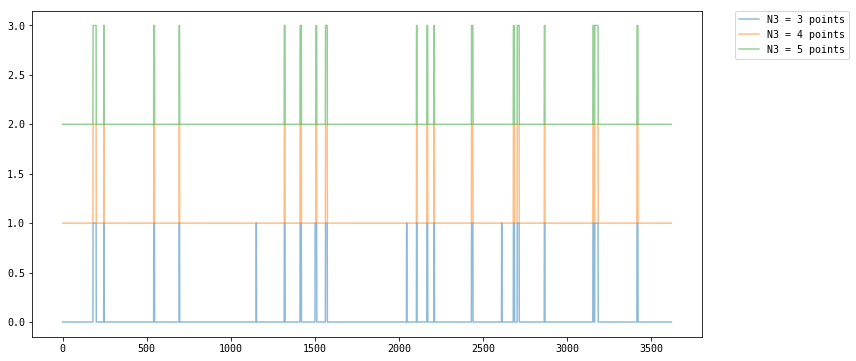

In [30]:
def calc_compdf(oid,tests):

    compdf = pd.DataFrame({'time':[0]*3800,'flux_gap':[0]*3800,'flux_model':[0]*3800,'istop':[0]*3800,'istart':[0]*3800})

    for (item,l) in tests:
        location = '{}/test{}/{}_flux.csv'.format(loc,item,oid)
        compdf_flux = pd.read_csv(location,usecols=['flux_gap','time','flux_model'])
        location_flares = '{}/test{}/{}_flares.csv'.format(loc,item,oid)
        compdf_flares = pd.read_csv(location_flares,usecols=['istart','istop'])
        c = compdf_flux.join(compdf_flares)
        compdf = compdf.join(c,rsuffix=item)
    compdf.drop(labels=['time','flux_gap','flux_model','istart','istop'],axis=1,inplace=True)
    compdf.dropna(axis=0, how='all',inplace=True)
    #print(compdf.tail())
    return compdf

def edges_to_bool(df,istart='istart',istop='istop'):
    rangeflare = []
    end=len(df)
    df = df[[istart,istop]]
    df = df.dropna(axis=0, how='all')
    for i,row in df.iterrows():
        rangeflare.append(list(range(int(row[istart]),int(row[istop]))))

    isflare = np.zeros(end)
    rangeflare = [item for sublist in rangeflare for item in sublist]

    np.put(isflare,rangeflare,np.ones_like(rangeflare))
    
    return isflare

compdf = calc_compdf(oid_list[3],tests)

for (item,l) in tests:
    compdf['isflare'+item] = edges_to_bool(compdf,istart='istart'+item,istop='istop'+item)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
i = 0
for (item,l) in tests:
    ax.plot(compdf['isflare'+item]+i,alpha=0.5,label='{} = {}'.format(name,l))
    i+=1
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.show()

## If the exploration above looks sensible, do the same for all light curves in the test sample added together

In [31]:
sample_bool = pd.DataFrame({'data':[0]*3800})
for oid in oid_list:
    OID = str(oid)
    cdf = calc_compdf(oid,tests)
    #print(cdf.head())
    c = [edges_to_bool(cdf,istart='istart'+item,istop='istop'+item) for (item,l) in tests]
    columns = ['{}{}'.format(OID,item) for (item,l) in tests]
    c = pd.DataFrame(np.array(c).T, columns=columns)
   # print(c.describe())
    #print(type(c1),len(c),type(c))
    sample_bool = sample_bool.join(c)

sample_bool.head()

,data,228682441_01,228682441_02,228682441_03,211410963_01,211410963_02,211410963_03,211411112_01,211411112_02,211411112_03,...,211427574_03,211409099_01,211409099_02,211409099_03,211405388_01,211405388_02,211405388_03,211411477_01,211411477_02,211411477_03
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


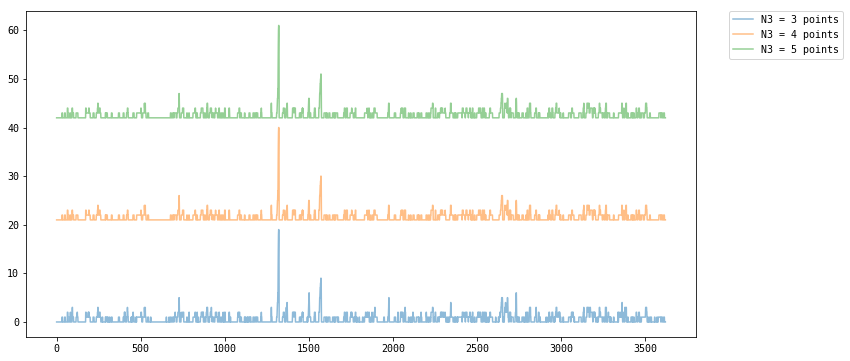

In [32]:
for (suffix,l) in tests:
    columns = [item for item in list(sample_bool.columns) if suffix in item]
    #print(columns)
    sample_bool[suffix] = sample_bool[columns].sum(axis=1)
sample_bool.dropna(axis=0,how='all',inplace=True)


f = plt.figure(figsize=(12,6))
ax = f.add_subplot(111)
for idx,(item,l) in enumerate(tests):
    ax.plot(sample_bool[item]+len(oid_list)*idx,alpha=0.5,label='{} = {}'.format(name,l))
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
f.show()

## Here difference in flare candidate recovery conditional on sigma clipping threshold is tes

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


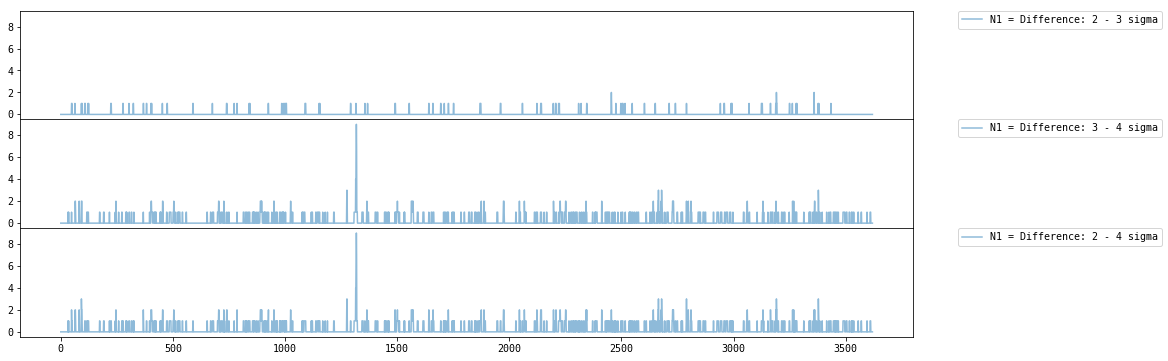

In [22]:
p, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True,figsize=(16,6))
ax1.plot(sample_bool['_06']-sample_bool['_01'],alpha=0.5,label='{} = Difference: 2 - 3 sigma'.format(name))
ax3.plot(sample_bool['_06']-sample_bool['_04'],alpha=0.5,label='{} = Difference: 2 - 4 sigma'.format(name))
ax2.plot(sample_bool['_01']-sample_bool['_04'],alpha=0.5,label='{} = Difference: 3 - 4 sigma'.format(name))
# Fine-tune figure; make subplots close to each other and hide x ticks for all but bottom plot.
p.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in p.axes[:-1]], visible=False)

ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p.show()

## Here the difference in flare candidate recovery conditional on sigma clipping threshold with photometric error included is tested

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


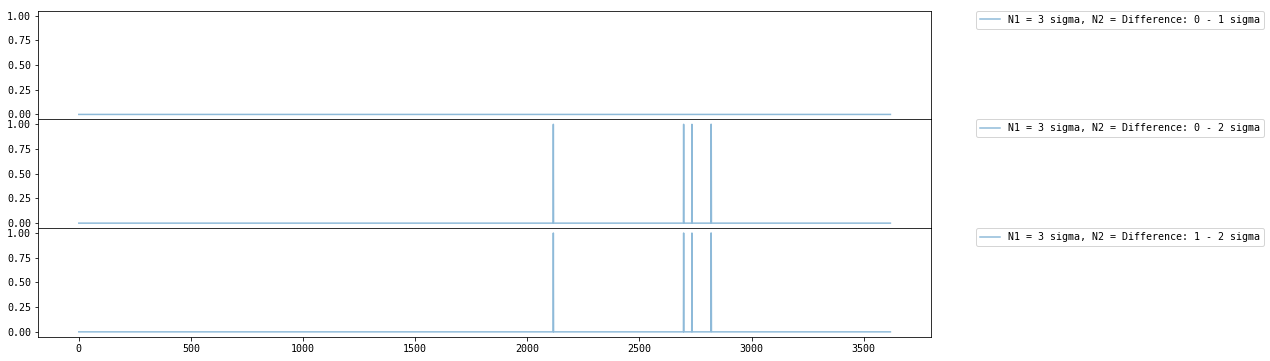

In [8]:
p, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True,figsize=(16,6))
ax1.plot(sample_bool['_10']-sample_bool['_09'],alpha=0.5,label='{} = Difference: 0 - 1 sigma'.format(name))
ax3.plot(sample_bool['_09']-sample_bool['_01'],alpha=0.5,label='{} = Difference: 1 - 2 sigma'.format(name))
ax2.plot(sample_bool['_10']-sample_bool['_01'],alpha=0.5,label='{} = Difference: 0 - 2 sigma'.format(name))
# Fine-tune figure; make subplots close to each other and hide x ticks for all but bottom plot.
p.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in p.axes[:-1]], visible=False)

ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p.show()

## Here the difference in flare candidate recovery conditional on number if consecutive points


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


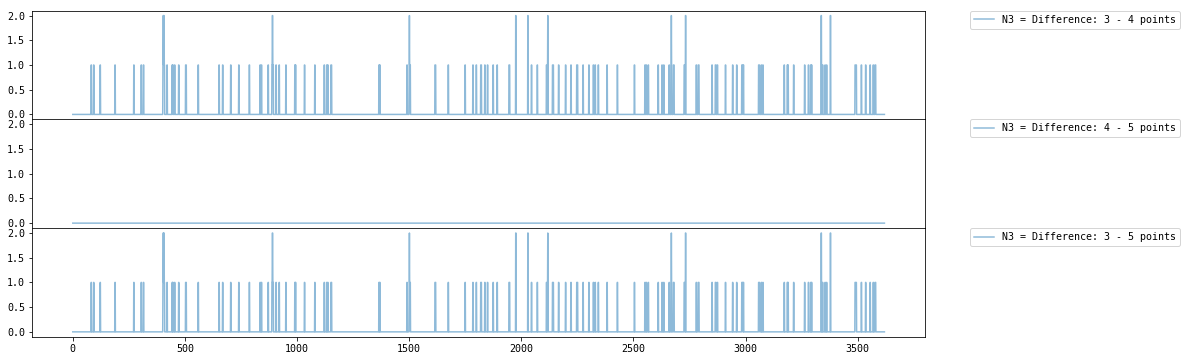

In [34]:
p, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True,figsize=(16,6))
ax1.plot(sample_bool['_01']-sample_bool['_02'],alpha=0.5,label='{} = Difference: 3 - 4 points'.format(name))
ax2.plot(sample_bool['_02']-sample_bool['_03'],alpha=0.5,label='{} = Difference: 4 - 5 points'.format(name))
ax3.plot(sample_bool['_01']-sample_bool['_03'],alpha=0.5,label='{} = Difference: 3 - 5 points'.format(name))
# Fine-tune figure; make subplots close to each other and hide x ticks for all but bottom plot.
p.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in p.axes[:-1]], visible=False)

ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p.show()